# **Timeseries of Control Run Metrics**

**Important metrics:**

- SH sea ice extent/volume
- regional sea ice extent/volume
- regional NPP, PCO2, SSS, SST
- gridpoint-level fields for sea ice concentration, SST, SSS, NPP, PCO2
- sea ice edge position (latitude at which sea ice concentration drops below 15%)

In [2]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

from PIL import Image

%load_ext autoreload
%autoreload 2
import hmei.processing as pcs
import hmei.visualization as vis

### Functions

In [2]:
## return the size of the dataset in gigabytes GB (not gibibytes GiB)
def xr_size(da):
    return str(da.nbytes / (1000**3))+' gigabytes'

## view contents of a directory
def dir_inspect(path):
    return sorted(os.listdir(path))

In [3]:
def open_ctrl_so(var, metric):
    write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir_ctrl = 'CTRL/'
    filename = write_rootdir+subdir_ctrl+var.upper()+'/'+var.lower()+'_ctrl_so_'+metric+'.nc'
    return xr.open_dataset(filename)

In [4]:
def open_ctrl_global(var, metric):
    write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir_ctrl = 'CTRL/'
    filename = write_rootdir+subdir_ctrl+var.upper()+'/'+var.lower()+'_ctrl_global_'+metric+'.nc'
    return xr.open_dataset(filename)

In [5]:
## opens raw data files from Froelicher et al. 2020 
## and formats the coordinate/variable names 
def open_raw_ctrl(var):
    rootdir = '/local/projects/so_predict/esm2m_froelicher/'
    subdir_ctrl = 'CTRL/'
    subdir_grid = 'GRID/'
    
    ocean_grid = xr.open_dataset(rootdir+subdir_grid+'ocean.static.nc')
    geolat_t = ocean_grid.geolat_t
    geolon_t = ocean_grid.geolon_t

    if (var.lower() == 'sst'):
        path = rootdir+subdir_ctrl+'SST/sst_*.nc'
        print(path)
        ds = xr.open_mfdataset(path)
        return ds
    
    elif (var.lower() == 'sss'):
        path = rootdir+subdir_ctrl+'SSS/sss_*.nc'
        print(path)
        ds = xr.open_mfdataset(path)
        ds = ds_sss.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})
        return ds
        
    elif (var.upper() == 'CN_INV'):
        path = rootdir+subdir_ctrl+'CN/CN_inv_*.nc'
        print(path)
        ds = xr.open_mfdataset(path)
        ds = ds.rename({'XT':'xt_ocean', 'YT':'yt_ocean', 'TIME':'time'})
        ds = ds.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})
        ds = ds.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})
        return ds
        
    elif (var.upper() == 'CN_INV'):
        path = rootdir+subdir_ctrl+'NPP/NPP_*.nc'
        print(path)
        ds = xr.open_mfdataset(path)
        ds = ds.rename({'XT_OCEAN':'xt_ocean', 'YT_OCEAN':'yt_ocean', 'TIME':'time'})
        ds = ds.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})
        return ds
    
    elif (var.lower() == 'pco2surf'):
        path = rootdir+subdir_ctrl+'PCO2SURF/pco2surf_*.nc'
        print(path)
        ds = xr.open_mfdataset(path)
        return ds

    else:
        print('<invalid parameters>')
        return

In [6]:
def open_gridcell_ctrl(var, metric=False, reg=False):
    write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir_ctrl = 'CTRL/'
    
    if (not reg) or (reg == 'global'):
        if (var.lower() == 'sie') or (var.lower() == 'siv'):
            filename = write_rootdir+subdir_ctrl+var.upper()+'/'+var.lower()+'_ctrl_so_timeseries.nc'
        else:
            filename = write_rootdir+subdir_ctrl+var.upper()+'/'+var.lower()+'_ctrl_global_'+metric+'.nc'
        print(filename)
        return xr.open_dataset(filename)
    
    elif (reg) or (reg.lower() == 'so') or (reg.lower() == 'southernocean'):
        if (var.lower() == 'sie') or (var.lower() == 'siv'):
            filename = write_rootdir+subdir_ctrl+var.upper()+'/'+var.lower()+'_ctrl_so_timeseries.nc'
        else:
            filename = write_rootdir+subdir_ctrl+var.upper()+'/'+var.lower()+'_ctrl_so_'+metric+'.nc'
        print(filename)
        return xr.open_dataset(filename)
    
    else:
        print('<invalid parameters>')
        return

### Import data (raw)

In [7]:
rootdir = '/local/projects/so_predict/esm2m_froelicher/'
subdir_ctrl = 'CTRL/'
subdir_grid = 'GRID/'

dir_inspect(rootdir+subdir_ctrl)

['CN', 'EXT', 'HI', 'MLD', 'NPP', 'PCO2SURF', 'SSS', 'SST']

In [8]:
ocean_grid = xr.open_dataset(rootdir+subdir_grid+'ocean.static.nc')

geolat_t = ocean_grid.geolat_t
geolon_t = ocean_grid.geolon_t

In [9]:
## SST
path_sst = rootdir+subdir_ctrl+'/SST/sst_*.nc'
ds_sst = xr.open_mfdataset(path_sst)

In [187]:
## SSS
path_sss = rootdir+subdir_ctrl+'/SSS/sss_*.nc'
ds_sss = xr.open_mfdataset(path_sss)

## add geolon_t and geolat_t coordinates
ds_sss = ds_sss.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

In [188]:
## SIC
path_cn = rootdir+subdir_ctrl+'/CN/CN_inv_*.nc'
var_cn = 'CN_INV'

ds_cn = xr.open_mfdataset(path_cn)

## change XT / YT to ocean model grid coordinates xt_ocean / yt_ocean
ds_cn = ds_cn.rename({'XT':'xt_ocean', 'YT':'yt_ocean', 'TIME':'time'})
ds_cn = ds_cn.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})

## add geolon_t and geolat_t coordinates
ds_cn = ds_cn.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

In [189]:
## NPP
path_npp = rootdir+subdir_ctrl+'/NPP/NPP_*.nc'
var_npp = 'NPP'

ds_npp = xr.open_mfdataset(path_npp)

## rename coordinates for continuity
ds_npp = ds_npp.rename({'XT_OCEAN':'xt_ocean', 'YT_OCEAN':'yt_ocean', 'TIME':'time'})

## add geolon_t and geolat_t coordinates
ds_npp = ds_npp.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

In [190]:
## pCO2
path_pco2surf = rootdir+subdir_ctrl+'/PCO2SURF/pco2surf_*.nc'
var_pco2surf = 'pco2surf'

ds_pco2surf = xr.open_mfdataset(path_pco2surf)

In [28]:
path_mld = rootdir+subdir_ctrl+'/MLD/mld_0*.nc'
var_mld = 'mld'

ds_mld = xr.open_mfdataset(path_mld)

### Import data (processed)

In [41]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

dir_inspect(write_rootdir+subdir_ctrl)

['CN_INV', 'MLD', 'NPP', 'PCO2SURF', 'SIE', 'SIV', 'SI_EDGE', 'SSS', 'SST']

In [192]:
## variable names
CN_INV = 'CN_INV'
NPP = 'NPP'
PCO2SURF = 'PCO2SURF'
SIE = 'SIE'
SIV = 'SIV'
SI_EDGE = 'SI_EDGE'
SSS = 'SSS'
SST = 'SST'

In [193]:
clim = 'climatology'
anom = 'anomaly'
var = 'variance'

sst_clim = open_ctrl_global(SST, clim) 
sst_anom = open_ctrl_global(SST, anom)
sst_variance = open_ctrl_global(SST, var)

sss_clim = open_ctrl_global(SSS, clim) 
sss_anom = open_ctrl_global(SSS, anom)
sss_variance = open_ctrl_global(SSS, var)

cn_clim = open_ctrl_global(CN_INV, clim) 
cn_anom = open_ctrl_global(CN_INV, anom)
cn_variance = open_ctrl_global(CN_INV, var)

npp_clim = open_ctrl_global(NPP, clim) 
npp_anom = open_ctrl_global(NPP, anom)
npp_variance = open_ctrl_global(NPP, var)

pco2surf_clim = open_ctrl_global(PCO2SURF, clim)
pco2surf_anom = open_ctrl_global(PCO2SURF, anom)
pco2surf_var = open_ctrl_global(PCO2SURF, var)

sie_path = write_rootdir+subdir_ctrl+SIE+'/'+'sie_ctrl_so_timeseries.nc'
sie_metrics = xr.open_dataset(sie_path)

siv_path = write_rootdir+subdir_ctrl+SIV+'/'+'siv_ctrl_so_timeseries.nc'
siv_metrics = xr.open_dataset(siv_path)

## SI_EDGE

In [42]:
reg_masks = xr.open_dataset(write_rootdir+'regional_global_masks.nc')

In [43]:
## keep for development of plotting function
for (reg, i) in zip(reg_masks.data_vars, range(6)):
    print(reg_masks[reg].attrs['long_name'] + ' (' + str(math.floor(i/2)) + ',' + str(i%2) + ')') 

Southern Ocean (0,0)
Weddell (0,1)
Indian (1,0)
West Pacific (1,1)
Ross (2,0)
Amundsen and Bellingshausen (2,1)


# Analysis

Test plot of Southern Ocean SST using Cartopy. I'm having trouble using the ```AzimuthalEquidistant``` projection with ```contourf()```. Advice on the best projection for the Southern Ocean would be helpful.

In [3]:
sst_gc_clim = xr.open_dataset('/home/bbuchovecky/storage/so_predict_derived/CTRL/SST/sst_gc_global_clim.nc')

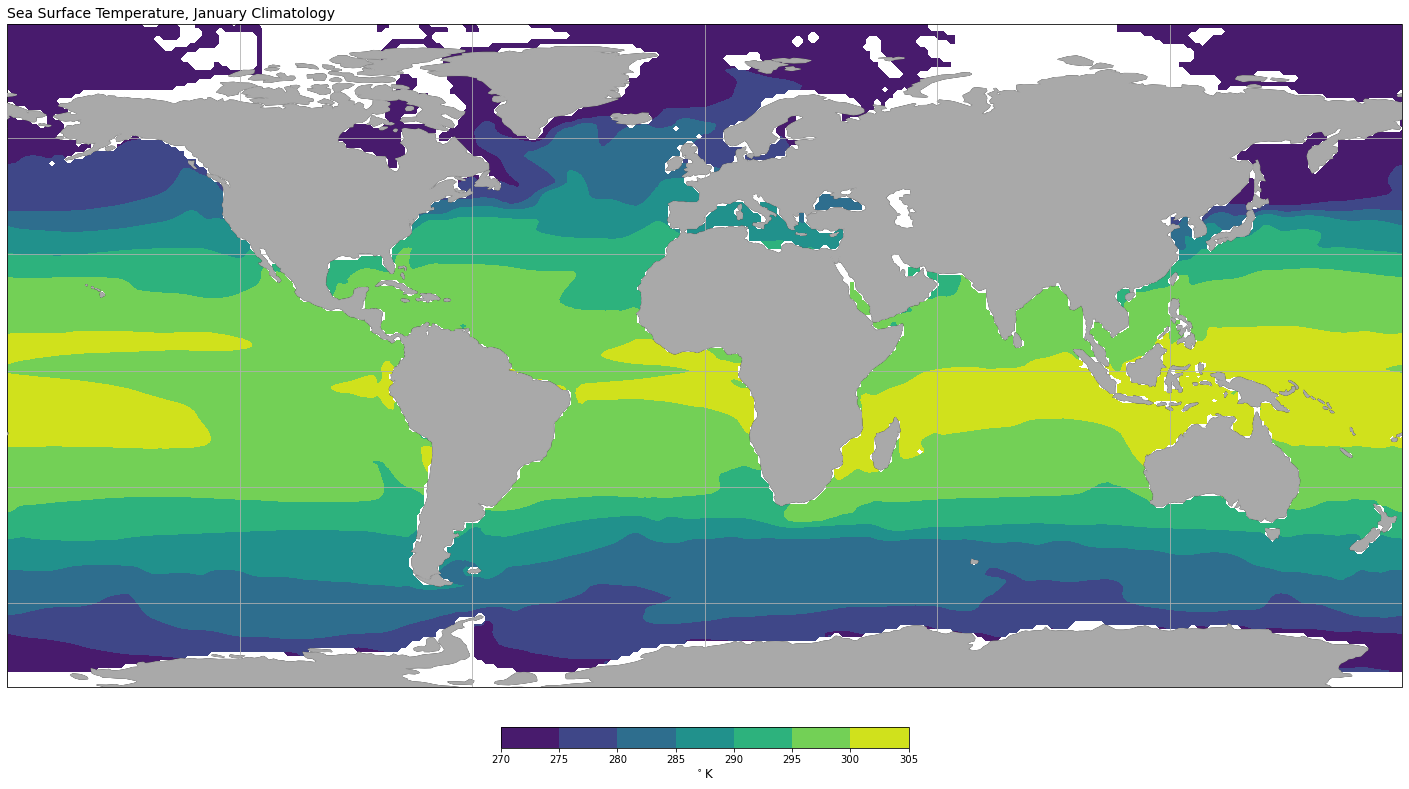

In [6]:
# crs = ccrs.AzimuthalEquidistant(0,-90)
# crs = ccrs.EquidistantConic(0.0, -40.5)
crs = ccrs.PlateCarree()

## geolat_t[:27,:] is equal to -55.5 degN
lat = 27 

fig,ax = plt.subplots(figsize=(10,5), subplot_kw={'projection':crs})

X = sst_gc_clim['xt_ocean']
Y = sst_gc_clim['yt_ocean']
Z = sst_gc_clim['sst_clim'][0].squeeze()

# ones = xr.where(sst_gc_clim['sst_clim'][0] > 0, 1, 0)
# Z = ones.squeeze()

Z, X = add_cyclic_point(Z, coord=X)

im = ax.contourf(X,Y,Z,transform=crs)

ax.add_feature(cfeature.LAND, zorder=10, facecolor='darkgray')
ax.gridlines()
ax.coastlines()

ax.set_title('Sea Surface Temperature, January Climatology', fontsize=14, loc='left')

cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.025,pad=0.05)
cbar.set_label('$^\circ$K',fontsize=12)

## Timeseries

In [35]:
## computes the regional or global mean of a variable
def reg_annual_mean(ds, var, ocean_grid, masks=False, reg=False):
    area = xr.where(np.isnan(ds[var][0]), np.nan, ocean_grid['area_t'])
    
    mask_bool = True
    if type(masks) == type(True):
        mask_bool = masks
    
    ## global mean
    if (not mask_bool) and (reg == False):
        area_sum = area.sum(dim={'xt_ocean', 'yt_ocean'})
        global_var = ds[var]
        annual_mean = (global_var * ocean_grid['area_t']).groupby('time.year').mean(dim='time').sum(dim={'xt_ocean', 'yt_ocean'}) / area_sum
        annual_mean.name = 'Global_' + var + '_annual_mean'
        return annual_mean
    
    ## mean for each region from masks parameter, returns a list of timeseries
    elif (mask_bool) and (reg == False):
        annual_mean = []
        for (reg, i) in zip(masks.data_vars, range(6)):
            area = area.where(masks[reg] == 1)
            area_sum = area.sum(dim={'xt_ocean', 'yt_ocean'})
            reg_var = ds[var].where(masks[reg] == 1)
            reg_mean = (reg_var * ocean_grid['area_t']).groupby('time.year').mean(dim='time').sum(dim={'xt_ocean', 'yt_ocean'}) / area_sum
            reg_mean.name = reg + '_' + var + '_annual_mean'
            annual_mean.append(reg_mean.copy(deep=True))
        return annual_mean
    
    ## mean for a single specified region from masks parameter
    elif (mask_bool) and (reg != False):
        area = area.where(masks[reg] == 1)
        area_sum = area.sum(dim={'xt_ocean', 'yt_ocean'})
        reg_var = ds[var].where(masks[reg] == 1)
        annual_mean = (reg_var * ocean_grid['area_t']).groupby('time.year').mean(dim='time').sum(dim={'xt_ocean', 'yt_ocean'}) / area_sum
        annual_mean.name = reg + '_' + var + '_annual_mean'
        return annual_mean
    
    else:
        print('<invalid parameters>')
        return

In [36]:
## computes the regional or global mean of a variable
def reg_annual_anom(ds, var, ocean_grid, masks=False, reg=False):
    area = xr.where(np.isnan(ds[var][0]), np.nan, ocean_grid['area_t'])
    
    mask_bool = True
    if type(masks) == type(True):
        mask_bool = masks

    ## global anomaly
    if (not mask_bool) and (reg == False):
        annual_mean = reg_annual_mean(ds, var, ocean_grid)
        single_mean = annual_mean.mean(dim='year')
        annual_anom = annual_mean - single_mean
        annual_anom.name = annual_anom.name.removesuffix('annual_mean') + 'yearly_anomaly'
        return annual_anom
        
    ## anomaly for each region from masks parameter, returns a list of timeseries
    elif (mask_bool) and (reg == False):
        annual_mean = reg_annual_mean(ds, var, ocean_grid, masks)
        single_mean = []
        for reg in annual_mean:
            single_mean.append(reg.mean(dim='year'))
            
        annual_anom = []
        for (t,m) in zip(annual_mean, single_mean):
            anom = t - m
            anom.name = anom.name.removesuffix('annual_mean') + 'yearly_anomaly'
            annual_anom.append(anom)
        return annual_anom
        
    ## anomaly for a single specified region from masks parameter
    elif (mask_bool) and (reg != False):
        annual_mean = reg_annual_mean(ds, var, ocean_grid, masks, reg)
        single_mean = annual_mean.mean(dim='year')
        annual_anom = annual_mean - single_mean
        annual_anom.name = anom.name.removesuffix('annual_mean') + 'yearly_anomaly'
        return annual_anom
        
    else:
        print('<invalid parameters>')
        return

In [46]:
## generates a timeseries plot of mean [variable] with all regions overlaid
## needs reg_masks already loaded
def ctrl_overlay_plot(reg_mean, title, ylabel, reg_masks=False, size=False):
    ## get masks if necessary
    if not reg_masks:
        write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
        reg_masks = xr.open_dataset(write_rootdir+'regional_global_masks.nc')
    
    ## figure settings
    if not size:
        size = (10,5)

    ## axes formatting
    years = np.arange(1,301,1)
    ens_yrs = [22,64,106,170,232,295]
    xlim = [1,300]
    size = (10,5)
    ls = '-'
    primary_width = 2
    secondary_width = 1
    # cmap = plt.get_cmap('tab10') ## need to use cmap(i)
    # cmap = ['#003f5c', '#444e86', '#955196', '#dd5182', '#ff6e54', '#ffa600'] ## equidistant colors
    cmap = ['black', 'red', 'blue', 'green', 'orange', 'magenta']
    
    ## create figure
    fig,ax = plt.subplots(figsize=size)
    
    ## plot all regions
    ax.plot(years, reg_mean[0], label='Southern Ocean', color=cmap[0], ls=ls, linewidth=primary_width, zorder=6)

    for (reg, i) in zip(reg_masks.data_vars, range(0,6)):
        if i !=0:
            reg_title = reg_masks[reg].attrs['long_name']
            ax.plot(years, reg_mean[i], label=reg_title, color=cmap[i], ls=ls, linewidth=secondary_width)

    ax.set(title=title, xlabel = 'Time (yr)', ylabel=ylabel, xlim=xlim);
    leg = ax.legend(bbox_to_anchor = (1.02, 1));
    for line in leg.get_lines():
        line.set_linewidth(4.0)

In [47]:
## generates individual timeseries plots of mean [variable] for each each region
## needs reg_masks already loaded
def ctrl_grid_plot(reg_mean, title, ylabel, reg_masks=False, style='equal'):
    ## get masks if necessary
    if not reg_masks:
        write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
        reg_masks = xr.open_dataset(write_rootdir+'regional_global_masks.nc')
    
    ## figure settings
    if style == 'center':
        rows = 4
        cols = 2
    else:
        rows = 3
        cols = 2
    size = (10,10)

    fig = plt.figure(constrained_layout=True, figsize=size)
    spec = gridspec.GridSpec(ncols=cols, nrows=rows, figure=fig)

    if style == 'center':
        ax1 = fig.add_subplot(spec[0,:])
        ax2 = fig.add_subplot(spec[1,0])
        ax3 = fig.add_subplot(spec[1,1])
        ax4 = fig.add_subplot(spec[2,1])
        ax5 = fig.add_subplot(spec[2,0])
        ax6 = fig.add_subplot(spec[3,0])
    else:
        ax1 = fig.add_subplot(spec[0,0])
        ax2 = fig.add_subplot(spec[0,1])
        ax3 = fig.add_subplot(spec[1,0])
        ax4 = fig.add_subplot(spec[1,1])
        ax5 = fig.add_subplot(spec[2,0])
        ax6 = fig.add_subplot(spec[2,1])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6]

    ## axes settings
    label_loc = 'left'
    years = np.arange(1,301,1)
    ens_yrs = [22,64,106,170,232,295]
    xlim = [1,300]
    size = (10,5)
    ls = '-'
    primary_width = 2
    secondary_width = 1.5
    # cmap = plt.get_cmap('tab10') ## need to use cmap(i)
    # cmap = ['#003f5c', '#444e86', '#955196', '#dd5182', '#ff6e54', '#ffa600'] ## equidistant colors
    cmap = ['black', 'red', 'blue', 'green', 'orange', 'magenta']
    fignum = 97
    
    min_ylim = float('inf')
    max_ylim = float('-inf')

    ## plot all regions
    for (reg, i) in zip(reg_masks.data_vars, range(6)):
        reg_title = reg_masks[reg].attrs['long_name']
        axes[i].plot(years, reg_mean[i], color=cmap[i], ls=ls, linewidth=secondary_width)
        axes[i].set(xlabel = 'Time (yr)', ylabel=ylabel, xlim=xlim, xticks=ens_yrs)
        axes[i].set_title('('+chr(fignum)+') '+reg_title, loc=label_loc)
        axes[i].autoscale(enable=True,axis='x',tight=True)
        fignum += 1
        
        this_ylim = axes[i].get_ylim()
        
        diff = this_ylim[1] - this_ylim[0]
        diff = math.floor(math.log(diff, 10))
        
        if this_ylim[0] < min_ylim:
            min_ylim = round(this_ylim[0], abs(diff)+1)
        if this_ylim[1] > max_ylim:
            max_ylim = round(this_ylim[1], abs(diff)+1)
    
    for i in range(6):
        axes[i].set_ylim(min_ylim, max_ylim)

    fig.suptitle(title, fontsize=16)

**Check methods:** To recreate the plot from Frolicher et al. 2020 paper, the global mean plots are a yearly average (I assume to remove the seasonal cycle).

In [51]:
sst_global_mean = reg_annual_mean(ds_sst, 'sst', ocean_grid)

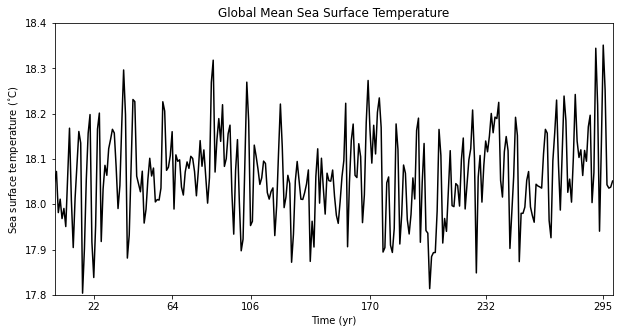

In [52]:
years = np.arange(1,301,1)
ens_yrs = [22,64,106,170,232,295]

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(years, sst_global_mean-273.15, 'k-')
ax.set(title='Global Mean Sea Surface Temperature', xlabel='Time (yr)', ylabel='Sea surface temperature ($^{\circ}$C)',
      xlim=[1,300], ylim=[17.8, 18.4], xticks=ens_yrs);

In [180]:
sst_global_anom = reg_annual_anom(ds_sst, 'sst', ocean_grid)

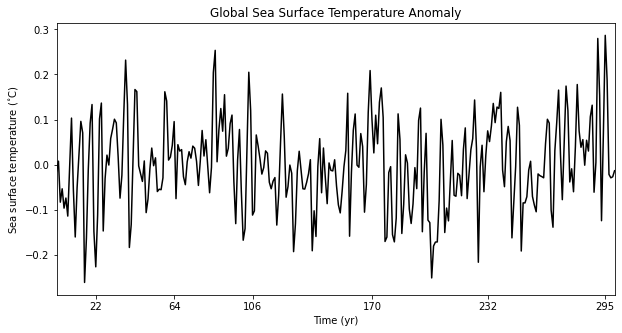

In [181]:
years = np.arange(1,301,1)
ens_yrs = [22,64,106,170,232,295]

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(years, sst_global_anom, 'k-')
ax.set(title='Global Sea Surface Temperature Anomaly', xlabel='Time (yr)', ylabel='Sea surface temperature ($^{\circ}$C)',
      xlim=[1,300], xticks=ens_yrs);

### SST

In [1]:
var = 'sst'
ds = ds_sst

sst_global_mean = reg_annual_mean(ds, var, ocean_grid)

sst_reg_mean = []
for reg in reg_masks.data_vars:
    sst_reg_mean.append(reg_annual_mean(ds, var, ocean_grid, reg_masks, reg) - 273.15)

NameError: name 'ds_sst' is not defined

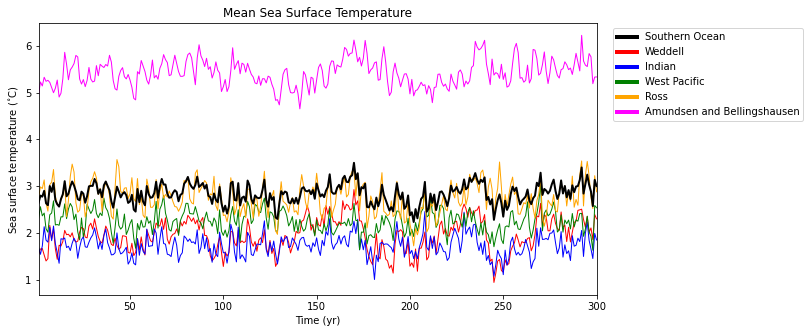

In [183]:
title = 'Mean Sea Surface Temperature'
ylabel = 'Sea surface temperature ($^{\circ}$C)'

ctrl_overlay_plot(sst_reg_mean, title, ylabel)

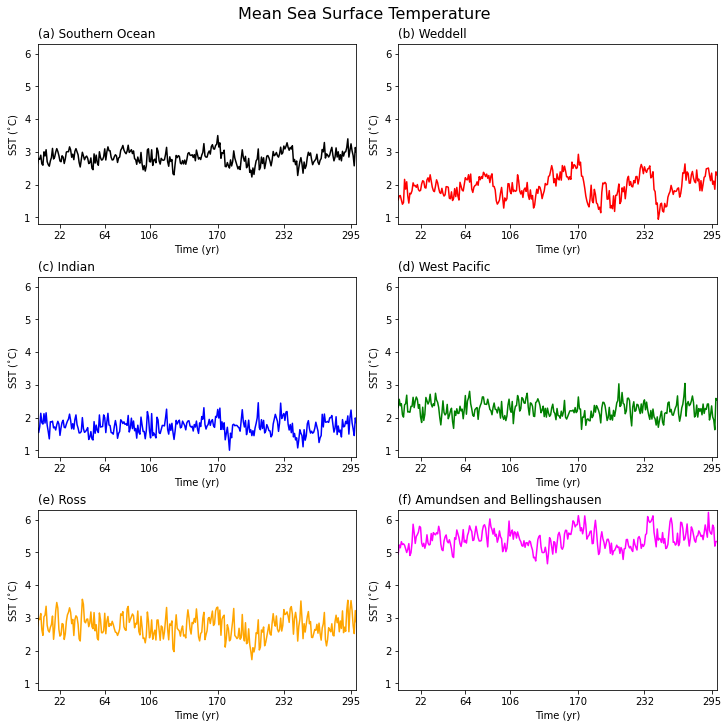

In [184]:
title = 'Mean Sea Surface Temperature'
ylabel = 'SST ($^{\circ}$C)'

ctrl_grid_plot(sst_reg_mean, title, ylabel)

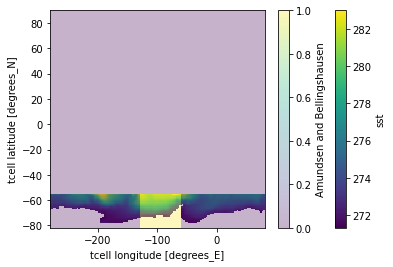

In [185]:
## The Amundsen and Bellingshausen region actually does have a significantly warmer mean SST.
ds_sst['sst'].where(reg_masks['SouthernOcean'] == 1).groupby('time.year').mean(dim='time').mean(dim='year').plot()
reg_masks['AmundBell'].plot(alpha=0.3)

### SSS

In [196]:
var = 'sss'
ds = ds_sss

sss_global_mean = reg_annual_mean(ds, var, ocean_grid, reg_masks, reg)

sss_reg_mean = []
for reg in reg_masks.data_vars:
    sss_reg_mean.append(reg_annual_mean(ds, var, ocean_grid, reg_masks, reg))

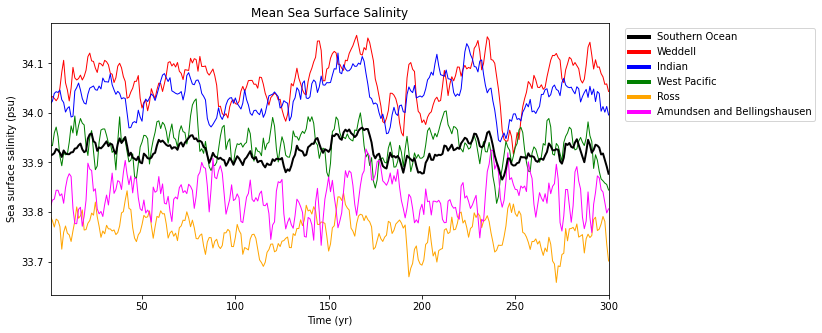

In [197]:
title = 'Mean Sea Surface Salinity'
ylabel = 'Sea surface salinity (psu)'

ctrl_overlay_plot(sss_reg_mean, title, ylabel)

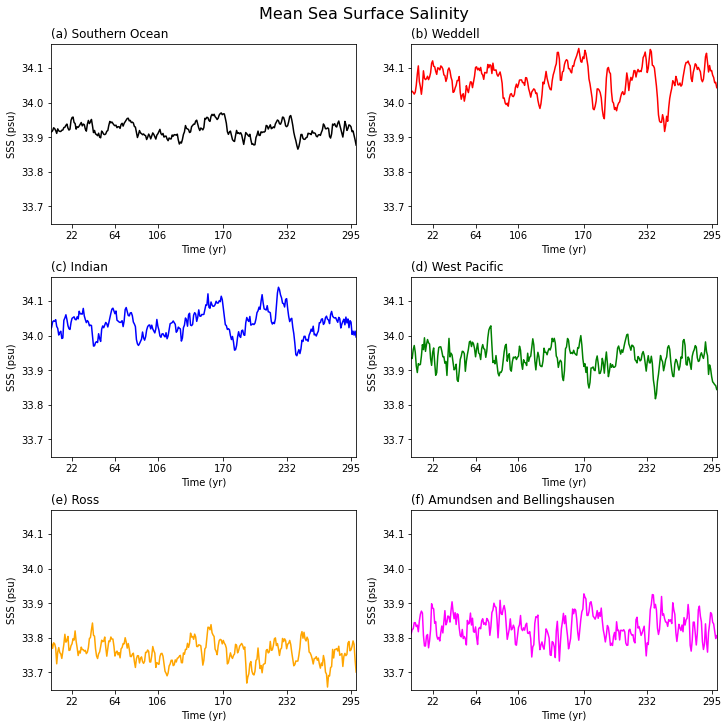

In [198]:
title = 'Mean Sea Surface Salinity'
ylabel = 'SSS (psu)'

ctrl_grid_plot(sss_reg_mean, title, ylabel)

### NPP

In [199]:
var = 'NPP'
ds = ds_npp

npp_global_mean = reg_annual_mean(ds, var, ocean_grid, reg_masks, reg)

npp_reg_mean = []
for reg in reg_masks.data_vars:
    npp_reg_mean.append(reg_annual_mean(ds, var, ocean_grid, reg_masks, reg))

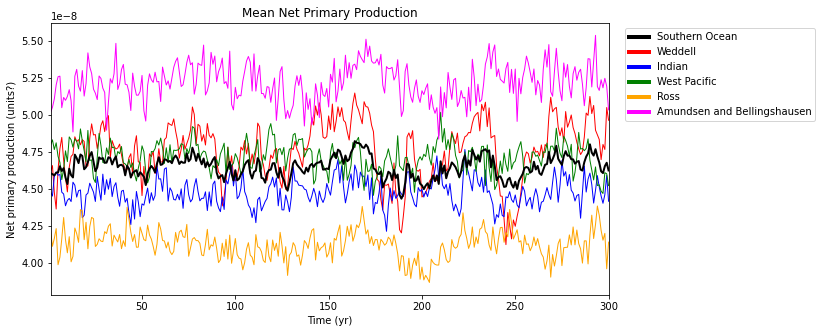

In [200]:
title = 'Mean Net Primary Production'
ylabel = 'Net primary production (units?)'

ctrl_overlay_plot(npp_reg_mean, title, ylabel)

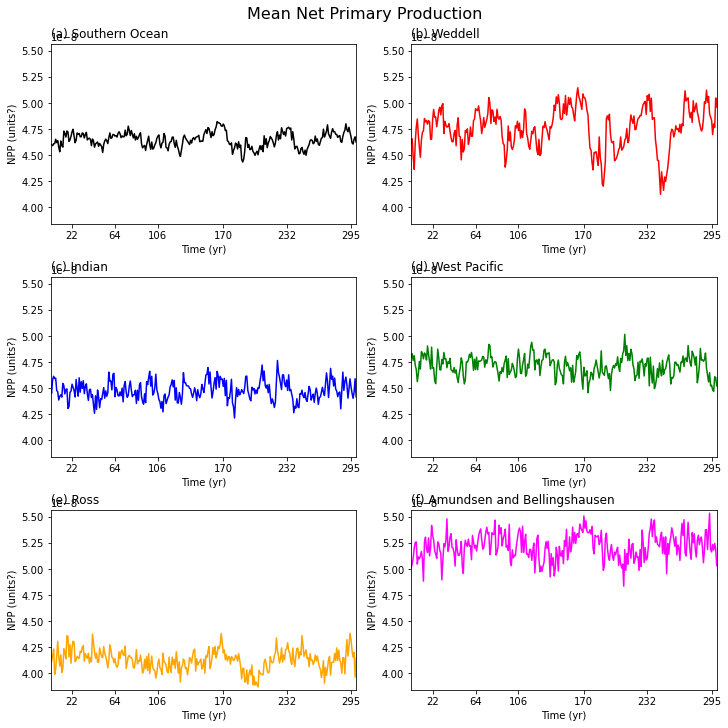

In [201]:
title = 'Mean Net Primary Production'
ylabel = 'NPP (units?)'

ctrl_grid_plot(npp_reg_mean, title, ylabel)

### pCO$_{2}$

In [202]:
var = 'pco2surf'
ds = ds_pco2surf

pco2surf_global_mean = reg_annual_mean(ds, var, ocean_grid, reg_masks, reg)

pco2surf_reg_mean = []
for reg in reg_masks.data_vars:
    pco2surf_reg_mean.append(reg_annual_mean(ds, var, ocean_grid, reg_masks, reg))

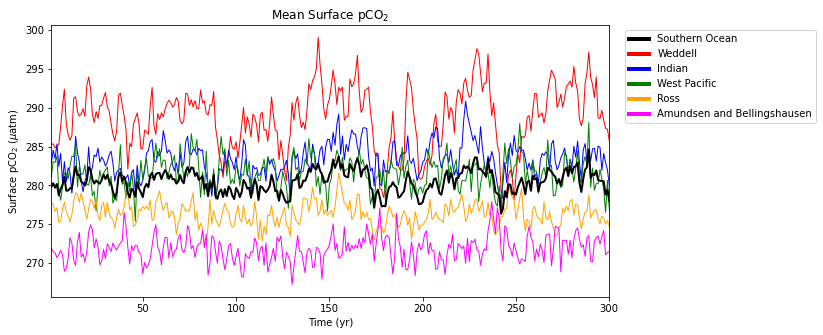

In [203]:
title = 'Mean Surface pCO$_{2}$'
ylabel = 'Surface pCO$_{2}$ ($\mu$atm)'

ctrl_overlay_plot(pco2surf_reg_mean, title, ylabel)

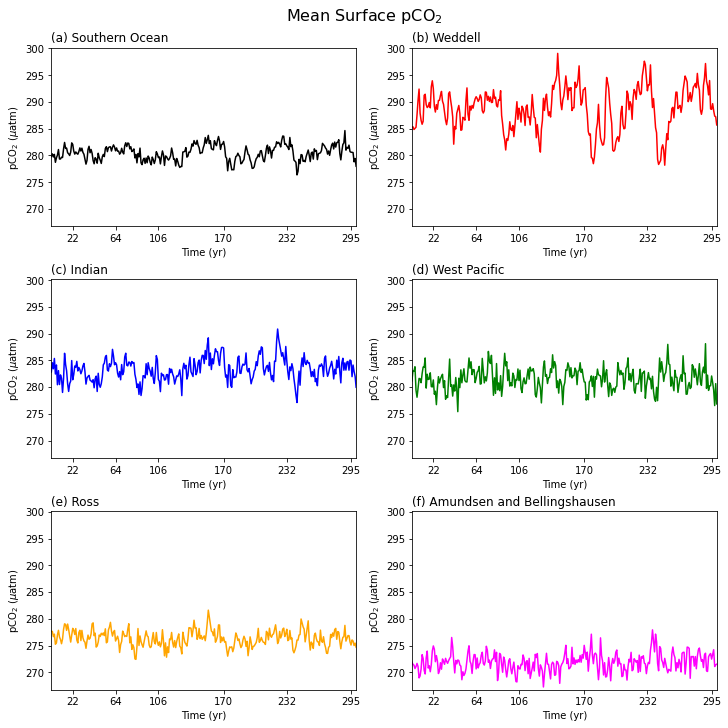

In [204]:
title = 'Mean Surface pCO$_{2}$'
ylabel = 'pCO$_{2}$ ($\mu$atm)'

ctrl_grid_plot(pco2surf_reg_mean, title, ylabel)

### SIC

In [205]:
var = 'CN_INV'
ds = ds_cn

cn_global_mean = reg_annual_mean(ds, var, ocean_grid, reg_masks, reg)

cn_reg_mean = []
for reg in reg_masks.data_vars:
    cn_reg_mean.append(reg_annual_mean(ds, var, ocean_grid, reg_masks, reg))

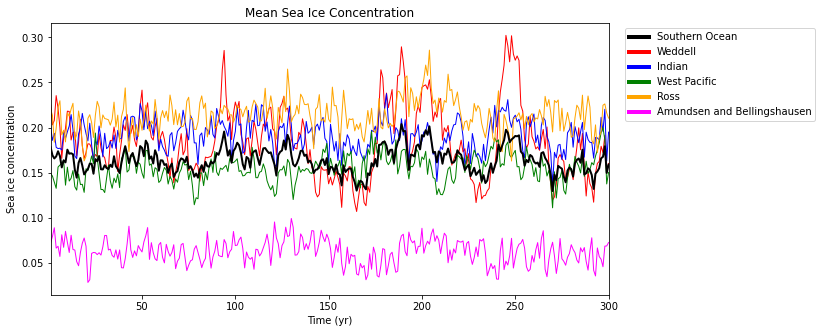

In [206]:
title = 'Mean Sea Ice Concentration'
ylabel = 'Sea ice concentration'

ctrl_overlay_plot(cn_reg_mean, title, ylabel)

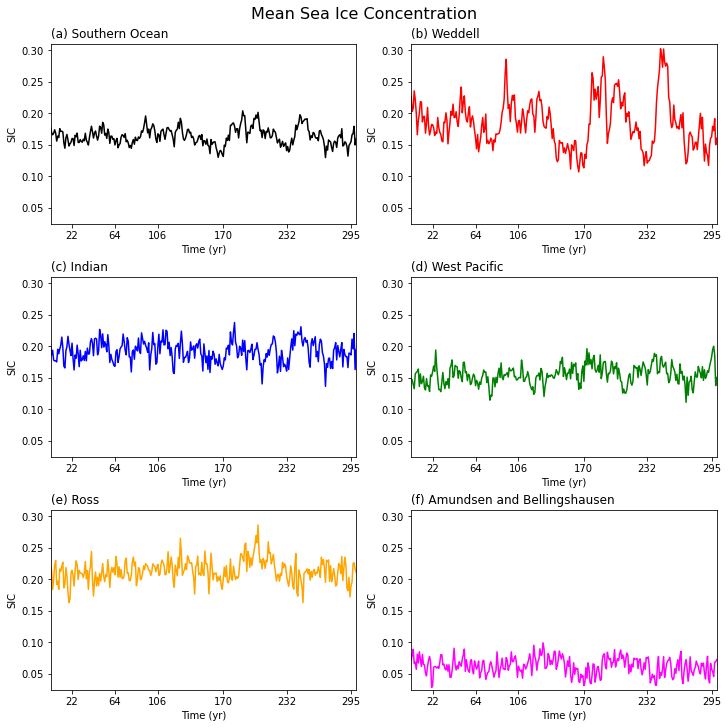

In [207]:
title = 'Mean Sea Ice Concentration'
ylabel = 'SIC'

ctrl_grid_plot(cn_reg_mean, title, ylabel)

### SIE

In [208]:
var = 'SIE_area'
ds = sie_metrics

sie_global_mean = reg_annual_mean(ds, var, ocean_grid, reg_masks, reg)

sie_reg_mean = []
for reg in reg_masks.data_vars:
    sie_reg_mean.append(reg_annual_mean(ds, var, ocean_grid, reg_masks, reg))

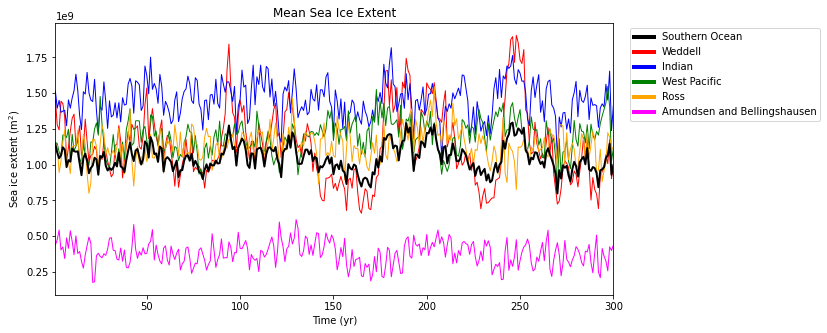

In [209]:
title = 'Mean Sea Ice Extent'
ylabel = 'Sea ice extent (m$^{2}$)'

ctrl_overlay_plot(sie_reg_mean, title, ylabel)

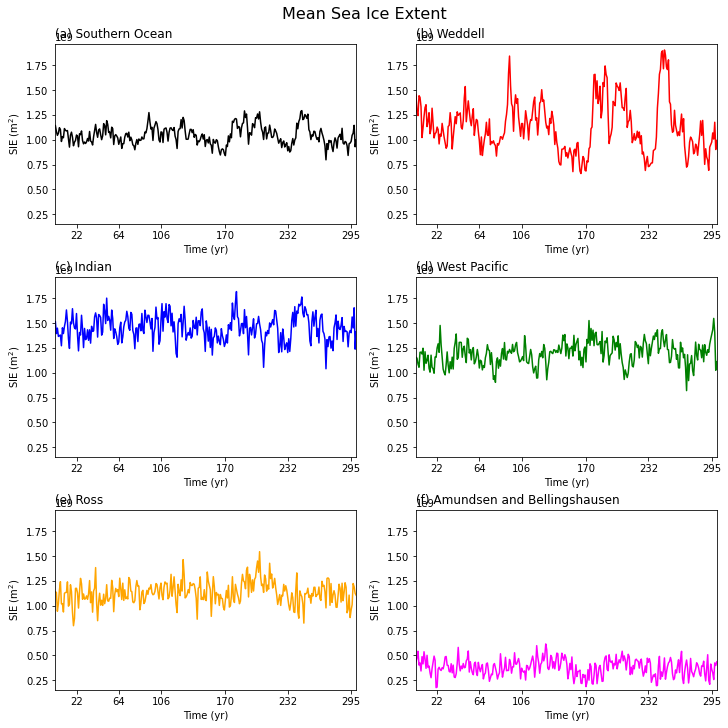

In [210]:
title = 'Mean Sea Ice Extent'
ylabel = 'SIE (m$^{2}$)'

ctrl_grid_plot(sie_reg_mean, title, ylabel)

### SIV

In [211]:
var = 'SIV_area'
ds = siv_metrics

siv_global_mean = reg_annual_mean(ds, var, ocean_grid, reg_masks, reg)

siv_reg_mean = []
for reg in reg_masks.data_vars:
    siv_reg_mean.append(reg_annual_mean(ds, var, ocean_grid, reg_masks, reg))

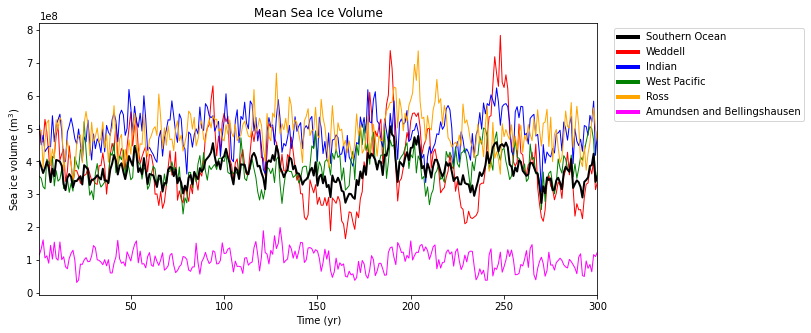

In [212]:
title = 'Mean Sea Ice Volume'
ylabel = 'Sea ice volume (m$^{3}$)'

ctrl_overlay_plot(siv_reg_mean, title, ylabel)

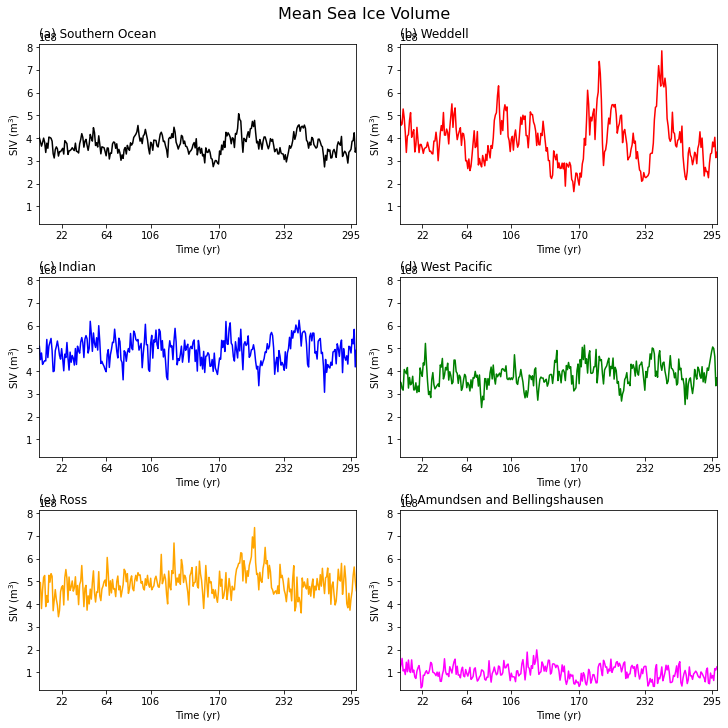

In [213]:
title = 'Mean Sea Ice Volume'
ylabel = 'SIV (m$^{3}$)'

ctrl_grid_plot(siv_reg_mean, title, ylabel)

### MLD

In [44]:
var = 'mld'
ds = ds_mld

mld_global_mean = reg_annual_mean(ds, var, ocean_grid, reg_masks, reg)

mld_reg_mean = []
for reg in reg_masks.data_vars:
    mld_reg_mean.append(reg_annual_mean(ds, var, ocean_grid, reg_masks, reg))

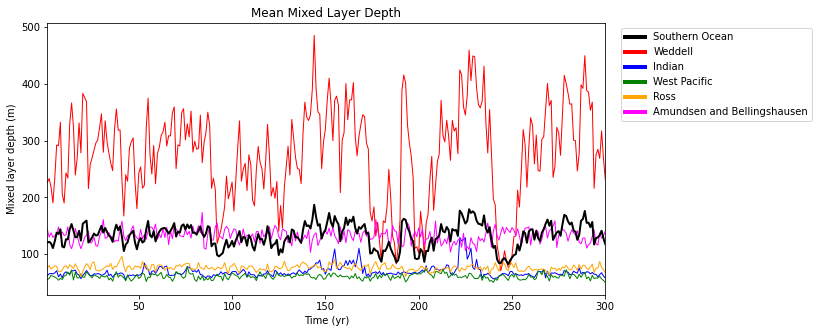

In [48]:
title = 'Mean Mixed Layer Depth'
ylabel = 'Mixed layer depth (m)'

ctrl_overlay_plot(mld_reg_mean, title, ylabel)

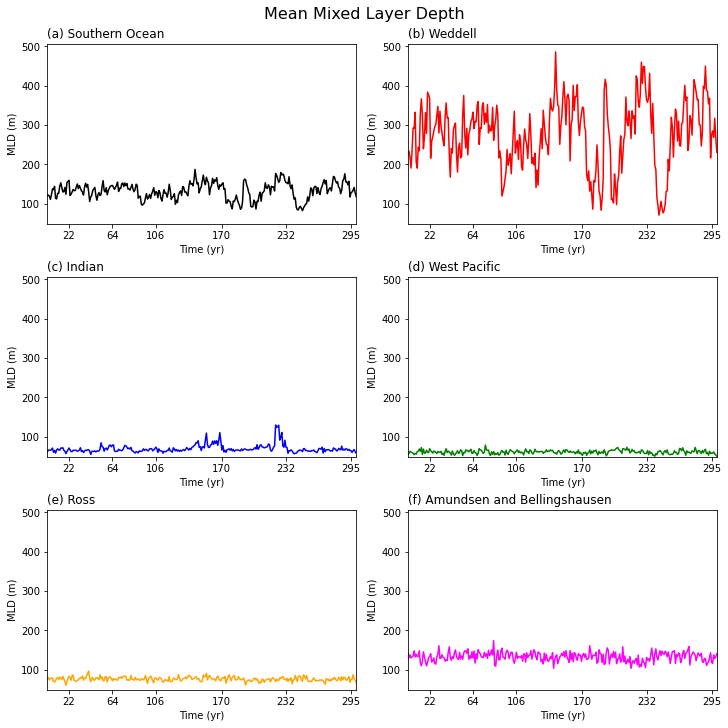

In [49]:
title = 'Mean Mixed Layer Depth'
ylabel = 'MLD (m)'

ctrl_grid_plot(mld_reg_mean, title, ylabel)

## **MISC**

[]

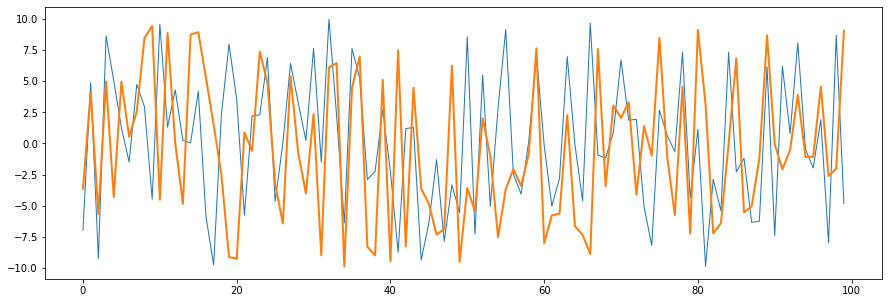

In [68]:
## FOR TESTING

X = np.arange(0,100)
Y1 = np.random.uniform(-10, 10, (100))
Y2 = np.random.uniform(-10, 10, (100))

fig,ax = plt.subplots(figsize=(15,5))
ax.plot(X, Y1, linewidth=1)
ax.plot(X, Y2, linewidth=2)
ax.plot()

Text(0.5, 0.98, 'Mean Sea Surface Temperature')

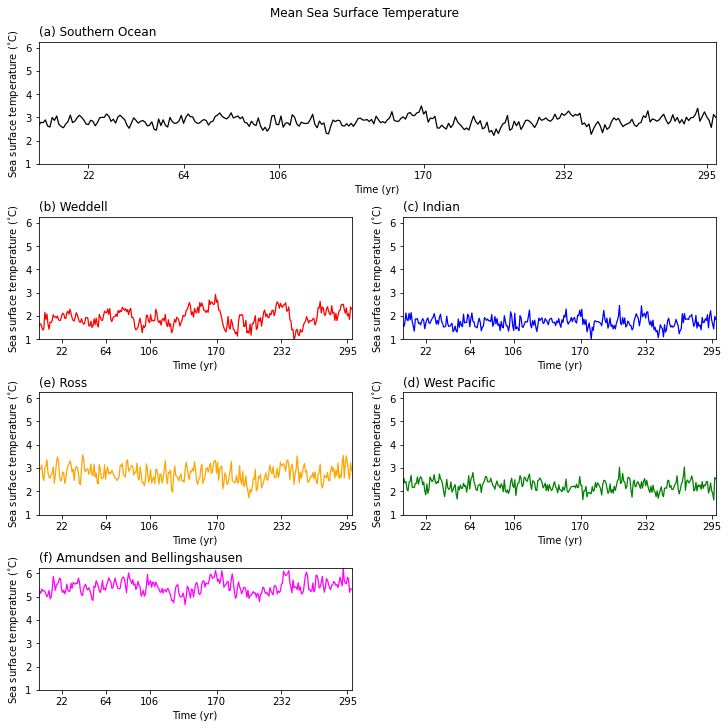

In [244]:
## EXAMPLE

## figure settings
rows = 4
cols = 2
size = (10,10)

fig = plt.figure(constrained_layout=True, figsize=size)
spec = gridspec.GridSpec(ncols=cols, nrows=rows, figure=fig)

ax1 = fig.add_subplot(spec[0,:])
ax2 = fig.add_subplot(spec[1,0])
ax3 = fig.add_subplot(spec[1,1])
ax4 = fig.add_subplot(spec[2,1])
ax5 = fig.add_subplot(spec[2,0])
ax6 = fig.add_subplot(spec[3,0])

axes = [ax1, ax2, ax3, ax4, ax5, ax6]

## axes settings
years = np.arange(0,300,1)
ens_yrs = [22,64,106,170,232,295]
xlim = [0,300]
ylim = [1,6.25]
ls = '-'
linewidth = 1.25
# cmap = plt.get_cmap('tab10') ## need to use cmap(i)
# cmap = ['#003f5c', '#444e86', '#955196', '#dd5182', '#ff6e54', '#ffa600'] ## equidistant colors
cmap = ['black', 'red', 'blue', 'green', 'orange', 'magenta']
fignum = 97

## plot all regions
for (reg, i) in zip(reg_masks.data_vars, range(6)):
    reg_title = reg_masks[reg].attrs['long_name']
    axes[i].plot(years, sst_reg_mean2[i]-273.15, color=cmap[i], ls=ls, linewidth=linewidth)
    axes[i].set(xlabel = 'Time (yr)', ylabel='Sea surface temperature ($^{\circ}$C)', xlim=xlim, ylim=ylim, xticks=ens_yrs)
    axes[i].set_title('('+chr(fignum)+') '+reg_title, loc='left')
    axes[i].autoscale(enable=True,axis='x',tight=True)
    fignum += 1

fig.suptitle('Mean Sea Surface Temperature')